#### Question 2

2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

Assumptions:
   * Next place a passenger hails a cab corresponds to the location with a bigger passager leads
   * City is divided by locations using the h3 package from ubber

In [5]:
import os
import sys
import pandas as pd
import h3
import folium
import numpy as np
import statsmodels.api as sm
from sklego.model_selection import TimeGapSplit
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pickle
from tbats import TBATS
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [6]:
# setting src package as a package
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [7]:
from d03_processing.q2 import (get_passenger_pickup_locations,
                               add_h3_hexes,
                               hex_selection
                              )
from d07_visualization.graphs import (mobility_map,
                                      visualize_hexagons,
                                      visualize_time_series
                                     )

#### Load data

In [9]:
# load final data
file_name = '../data/03_processed/cab_data_wo_outliers_velocity_method.parquet'
cab_data = pd.read_parquet(file_name)

#### Evaluate pickup locations

In [10]:
# we are only interested in the picking clients part so we need to get the places were a passanger is picked
passanger_pickup_locations =get_passenger_pickup_locations(cab_data)

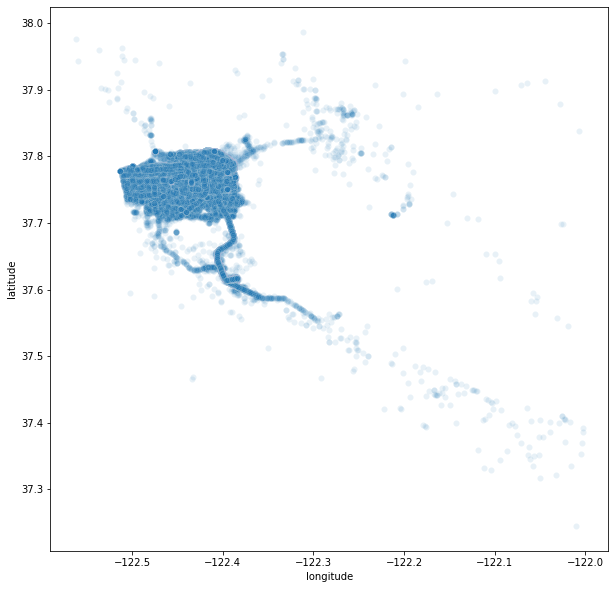

In [6]:
# as expected most of the pickups are arround downtown and at the airport
# a strange thing is that there are a lot of pickups at the highway going to the airport, can they pick clients there?
mobility_map(passanger_pickup_locations)

In [12]:
# now I add the hex id to the pickup data
APERTURE_SIZE = 7
passanger_pickup_locations_w_h3_hex = add_h3_hexes(passanger_pickup_locations, APERTURE_SIZE)

In [8]:
# and plots all the hexes on the map
# as expected and seen at the previous map there are pickups everywhere in san francisco
m = visualize_hexagons(passanger_pickup_locations_w_h3_hex.h3_hex.unique())
display(m)

In [9]:
# there seems to be some hexes that only have one pickup
# so we will just consider only a part of the hexes
passanger_pickup_locations_w_h3_hex.h3_hex.value_counts()

87283082affffff    119514
87283082bffffff    113678
872830828ffffff     52324
872830829ffffff     31277
87283082dffffff     24205
                    ...  
872830805ffffff         1
872834668ffffff         1
87283476bffffff         1
872834609ffffff         1
8728309abffffff         1
Name: h3_hex, Length: 213, dtype: int64

In [13]:
# for this evaluation lets only select the hexes that have more that 1000 pickups
hex_bigger_1000 = hex_selection(passanger_pickup_locations_w_h3_hex, 100)

In [166]:
# we plots the new hex list
# as expected the top pickup places are arround downtown and the airport
m = visualize_hexagons(hex_bigger_1000.h3_hex.unique())
display(m)

#### Evaluate pickup variation over time of the top location

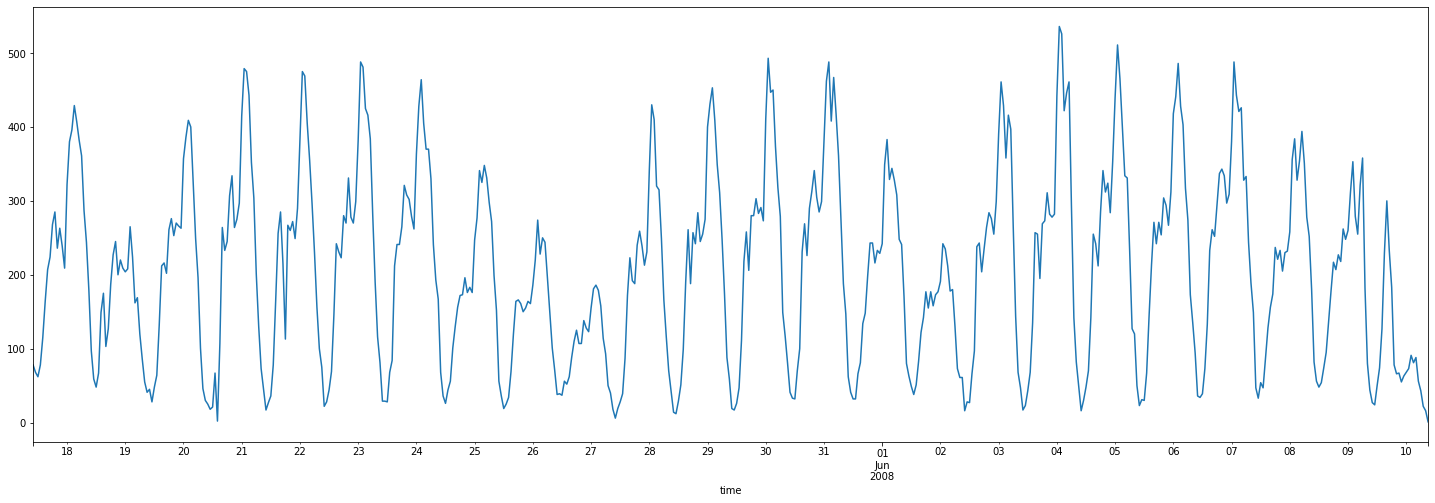

In [195]:
# lets evaluate the pickup behaviour of the top hex
# it seems to be 2 types of seasonality, one daily and another weeekly (or similar)
top_hex = (
    passanger_pickup_locations_w_h3_hex
    .query('h3_hex == "87283082affffff"')
    .set_index('time')
    .loc[:, 'occupancy']
    .resample('H')
    .sum()
)
visualize_time_series(top_hex)

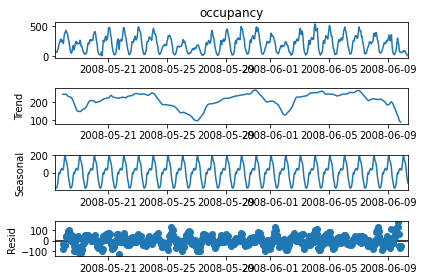

In [197]:
# but lets confirm it first
# and there it is, the daily seasonality, however, as expected we have a second type of seasonality
res_d = sm.tsa.seasonal_decompose(top_hex,period=24)
fig = res_d.plot()

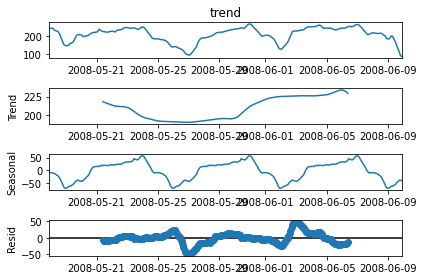

In [14]:
# and so it seems we have two types of seasonality
# however, it seems that the white noise is not that white... 
# it seems that the 26 was a holiday (memorial day) which confirms the smaller week cycle at that week
res_w = sm.tsa.seasonal_decompose(res_d.trend.dropna(),period=24*7)
fig = res_w.plot()

#### Model evaluation

My approach was to, for each hex in the top list, create a predictive model of the number of pickups over time.
Using this model I can predict the pickups rate for each hour in the next day and give to the cab driver the most probable place where a passanger will hail a cab

In [33]:
# First we need to split the time series in train and test set
# test will only represetn a day, sunday
def train_test_split(df, train_end_time, test_end_time):
    train = df.query(f'time < "{train_end_time}"')
    test = df.query(f'time > "{train_end_time}" and time < "{test_end_time}"')
    
    return train, test

train, test = train_test_split(passanger_pickup_locations_w_h3_hex, "2008-06-08 00:00:00", "2008-06-09 00:00:00")

In [169]:
# next I need to create of hourly pickup rates for the top hexes
def list_hex(hex_data, hex_list):
    
    # hex data list
    data_list = []
    
    # cylce each hex
    for hex_value in hex_list.h3_hex:
        
        # formats the selected hex data
        selected_hex_data = (
            hex_data
            .query(f'h3_hex == "{hex_value}"')
            .set_index('time')
            ['occupancy']
            .resample('H')
            .sum()
            .to_frame()
            .assign(h3_hex = hex_value)
        )

        # apends the hex data to the hex data list
        data_list.append(selected_hex_data)
        
    return data_list
        
hex_data_list = list_hex(passanger_pickup_locations_w_h3_hex, hex_bigger_1000)

#### Baseline model

* First I will train a baseline model to work as a benchmark.
*This model simply uses the average of the last 24 hours to predict the next 24 hours. 

In [174]:
# definition of the cv function for the baseline model
def baseline_cv(df):
    
    # definition of the data lists
    rmse_error_list=[]
    mea_error_list=[]
    mape_error_list=[]
    results = []
    
    # definition of the timeseries split
    tscv = TimeSeriesSplit(n_splits=4, test_size=24)
    
    # error calculation for each of the time splits
    for train_index, test_index in tscv.split(df):
        
        # defines the train and test data
        model_train = df.iloc[train_index]['occupancy']
        model_test = df.iloc[test_index]['occupancy']

        # makes forecast
        last_value = model_train.iloc[-1]
        forecast = len(model_test)*[np.mean(model_train.iloc[:-24])]
        
        # stores the errors
        rmse_error_list.append(mean_squared_error(model_test, forecast, squared=False))
        mea_error_list.append(mean_absolute_error(model_test, forecast))
        mape_error_list.append(mean_absolute_percentage_error(model_test, forecast))
    
    # calculates the errors mean
    rmse_error = np.mean(rmse_error_list)
    mea_error = np.mean(mea_error_list)
    mape_error = np.mean(mape_error_list)
    
    # gets the hex id
    h3_hex = df.iloc[0]['h3_hex']
    
    # converts the results to a dataframe
    result = pd.DataFrame([h3_hex, rmse_error,  mea_error, mape_error],
                         index = ['h3_hex','cv_RMSE', 'cv_MAE', 'cv_MAPE']).T
    
    return result

In [175]:
# basic pipeline for hex evaluation
def baseline_evaluation(hex_data_list):
    
    # results list
    results = []
    
    # evaluates all the hexes in the list
    for hex_data in hex_data_list:
    
        # calculates and stores the cv results
        result = baseline_cv(hex_data)
        results.append(result)
            
    return pd.concat(results)

# calls the hex cv function and stores the data
results_baseline = baseline_evaluation(hex_data_list)
pickle.dump(results_baseline, open('../data/05_reporting/baseline.pickle', 'wb'))

#### Sarimax evaluation

* Next I used the Sarima model, since, normally its a quite simple and robust type of forecasting model
* For each hex I test various models configurations to evaluate wich one is better

In [19]:
# configuration list definition
def sarima_configs():
    models = []
    p_params = range(2)
    d_params = range(2)
    q_params = range(2)
    t_params = ['c']
    P_params = range(2)
    D_params = range(2)
    Q_params = range(2)
    
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                cfg = [(p, d, q), (P, D, Q, 24), t]
                                models.append(cfg)
                                    
    return models

configs_list = sarima_configs()

In [20]:
# definition of the cv function for the baseline model
def sarimax_cv(df, config):
    
    # error list definition
    rmse_error_list=[]
    mea_error_list=[]
    mape_error_list=[]
    
    # model parameters from configuration 
    order, sorder, trend = config
    
    # definition of the timeseries split
    tscv = TimeSeriesSplit(n_splits=4, test_size=24)
    
    # error calculation for each of the time splits
    for train_index, test_index in tscv.split(df):
        
        # definition of the train and test data
        model_train = df.iloc[train_index]['occupancy']
        model_test = df.iloc[test_index]['occupancy']
        
        # model training using configuration values and forecasting
        model = sm.tsa.statespace.SARIMAX(endog=model_train, order=order, seasonal_order=sorder, trend=trend,
                                          enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        forecast = model_fit.forecast(24)

        # stores the errors
        rmse_error_list.append(mean_squared_error(model_test, forecast, squared=False))
        mea_error_list.append(mean_absolute_error(model_test, forecast))
        mape_error_list.append(mean_absolute_percentage_error(model_test, forecast))
    
    # calculates the errors mean
    rmse_error = np.mean(rmse_error_list)
    mea_error = np.mean(mea_error_list)
    mape_error = np.mean(mape_error_list)
    
    # gets the hex id
    h3_hex = df.iloc[0]['h3_hex']
    
    # converts the results to a dataframe
    result = pd.DataFrame({'h3_hex': h3_hex, 'config': [config], 
                            'cv_RMSE': rmse_error, 'cv_MAE': mea_error, 'cv_MAPE': mape_error})
    
    return result

In [7]:
# basic pipeline for hex evaluation
def sarimax_evaluation(hex_data_list, configs_list):
    
    # results list
    results = []
    
    # hex evaluation cycle
    for hex_data in hex_data_list:
        
        # config list definition
        configs_list = sarima_configs()
        
        # config evaluation cycle
        for config in configs_list:
            
            # calculates and stores the cv results
            result = sarimax_cv(hex_data, config)
            results.append(result)
            
    return pd.concat(results)
          
# calls the hex cv function and stores the data
results_sarimax = sarimax_evaluation(hex_data_list, configs_list)
pickle.dump(results_sarimax, open('../data/05_reporting/sarimax.pickle', 'wb'))

#### TBATS evaluation

* I will also test TBATS because it normally performs well in timeseries with multiple seasonalities, which is the case

In [12]:
# definition of the cv function for the baseline model
def tbats_cv(df):
    
    # error list definition
    rmse_error_list=[]
    mea_error_list=[]
    mape_error_list=[]
    
     # definition of the timeseries split
    tscv = TimeSeriesSplit(n_splits=4, test_size=24)
    
     # error calculation for each of the time splits
    for train_index, test_index in tscv.split(df):
        
        # definition of the train and test data
        model_train = df.iloc[train_index]['occupancy']
        model_test = df.iloc[test_index]['occupancy']
        
         # model training using configuration values and forecasting
        estimator = TBATS(seasonal_periods=(24, 24*7))
        model = estimator.fit(model_train)
        forecast = model.forecast(steps=24)

        # stores the errors
        rmse_error_list.append(mean_squared_error(model_test, forecast, squared=False))
        mea_error_list.append(mean_absolute_error(model_test, forecast))
        mape_error_list.append(mean_absolute_percentage_error(model_test, forecast))
    
    # calculates the errors mean
    rmse_error = np.mean(rmse_error_list)
    mea_error = np.mean(mea_error_list)
    mape_error = np.mean(mape_error_list)
    
    # gets the hex id
    h3_hex = df.iloc[0]['h3_hex']
    
    # converts the results to a dataframe
    result = pd.DataFrame([h3_hex, rmse_error,  mea_error, mape_error],
                           index = ['h3_hex','cv_RMSE', 'cv_MAE', 'cv_MAPE']).T
    
    return result

In [79]:
# basic pipeline for hex evaluation
def tbats_evaluation(hex_data_list):
    
    # results list
    results = []
    
    # hex evaluation cycle
    for hex_data in hex_data_list:
        
         # calculates and stores the cv results
        result = tbats_cv(hex_data)
        results.append(result)
            
    return pd.concat(results)

# calls the hex cv function and stores the data
results_tbats = tbats_evaluation(hex_data_list)
pickle.dump(results_tbats, open('../data/05_reporting/tbats.pickle', 'wb'))

#### Model error evaluation

* Next I'll compare the errors for each of the models and determine which one to use for each of the hexes

In [14]:
# load cv results
baseline_cv = pickle.load(open('../data/05_reporting/baseline.pickle', 'rb'))
sarima_cv = pickle.load(open('../data/05_reporting/sarimax.pickle', 'rb'))
tbats_cv = pickle.load(open('../data/05_reporting/tbats.pickle', 'rb'))

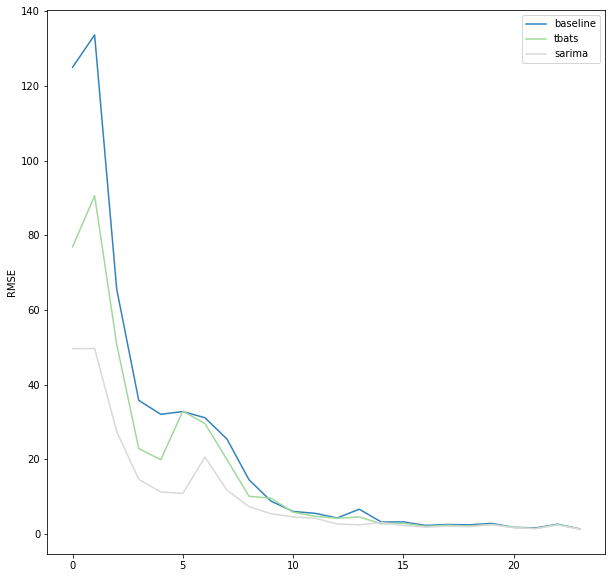

In [40]:
# Compare the errors and decide the best model per hex
# sarima seems to be the best option in most of the cases, so for simplicity I'll always use this model to make the predictions
h3_hex_list = []
baseline_list = []
tbats_list = []
sarima_list = []

for h3_hex in hex_bigger_1000.h3_hex.unique():
    
    if len(sarima_cv.query(f'h3_hex == "{h3_hex}"')):
        
        # adds hex to the list
        h3_hex_list.append(h3_hex)
  
        # calculates and adds the baseline error to the list
        baseline_error = (
            baseline_cv
            .query(f'h3_hex == "{h3_hex}"')
            .cv_RMSE
            .iloc[0]
        )
        baseline_list.append(baseline_error)

        # calculates and adds the tbats error to the list
        tbats_error = (
            tbats_cv
            .query(f'h3_hex == "{h3_hex}"')
            .cv_RMSE
            .iloc[0]
        )
        tbats_list.append(tbats_error)

        # calculates and adds the sarima error to the list
        sarima_error = (
            sarima_cv
            .query(f'h3_hex == "{h3_hex}"')
            .sort_values(by='cv_RMSE')
            .iloc[0,:]
            .cv_RMSE
        )
        sarima_list.append(sarima_error)

# convert errors to datafram and plot graph
errors = pd.DataFrame({'h3_hex': h3_hex_list, 'baseline':baseline_list, 'tbats':tbats_list, 'sarima':sarima_list})
ax = errors.plot(figsize=(10, 10), colormap='tab20c', ylabel='RMSE')
fig = ax.get_figure()
fig.savefig('errors.png')

#### Passagers hailing cabs prediction

* Now that I have a base model to work with, I can predict the passangers pickups in each of the hexes and give to the cab drivers the most likelly place where a passanger will hail a cab

In [34]:
# get the hex locations to predict
predict_train = train.loc[train['h3_hex'].isin(hex_bigger_1000.h3_hex.to_list())]
predict_test = test.loc[test['h3_hex'].isin(hex_bigger_1000.h3_hex.to_list())]

In [35]:
# make prediction for the next day (sunday)
next_day_results = []

for h3_hex in hex_bigger_1000.h3_hex.unique():
    
    if len(sarima_cv.query(f'h3_hex == "{h3_hex}"')):
        
        # get sarima config
        config_file = (
            sarima_cv
            .query(f'h3_hex == "{h3_hex}"')
            .sort_values(by='cv_RMSE')
            .iloc[0,:]
            .config
        )
        
        # prepares train data
        train_data = (
            predict_train
            .query(f'h3_hex == "{h3_hex}"')
            .set_index('time')
            ['occupancy']
            .resample('H')
            .sum()
        )
        
        # makes forecast for the next day
        order, sorder, trend = config_file
        model = sm.tsa.statespace.SARIMAX(endog=train_data, order=order, seasonal_order=sorder, trend=trend,
                                          enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit()
        forecast = model_fit.forecast(24)
        
        # appends forecast to data frame
        results_df = pd.DataFrame(forecast).rename(columns={'predicted_mean': h3_hex})
        next_day_results.append(results_df)
        
# converts results list to dataframe
final_predictions = pd.concat(next_day_results, axis=1)

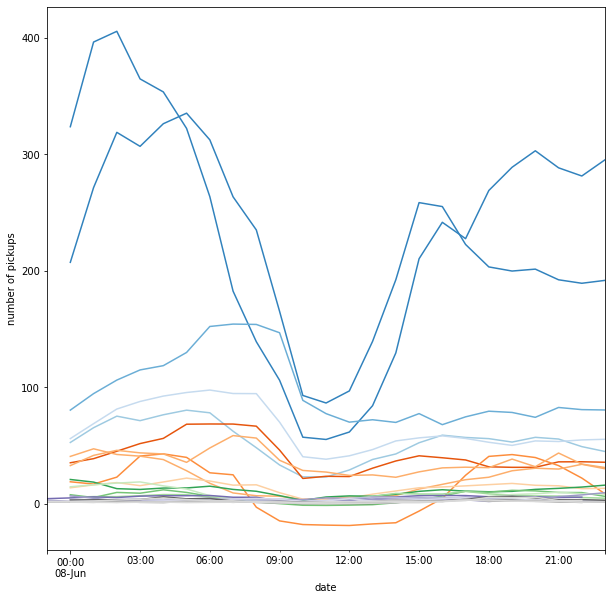

In [44]:
ax = final_predictions.plot(figsize=(10, 10), colormap='tab20c', ylabel='number of pickups', xlabel='date', legend=False)
fig = ax.get_figure()
fig.savefig('prediction.png')

In [134]:
# visualizing the 3 hexes
# all three are located at the downtown of san francisco, which makes sense since it is sunday
m = visualize_hexagons(['87283082affffff', '87283082bffffff', '872830828ffffff'])
display(m)

In [182]:
# next I need to calculate the errors for the next day prediction

# list definition
hex_list = []
rmse_error_list=[]
mea_error_list=[]
mape_error_list=[]

# h3_hex evaluation cycle
for h3_hex in final_predictions.columns:
    
    # gets prediction
    prediction = final_predictions[[h3_hex]].dropna()
    
    # prepares test data
    test = (
        predict_test
        .query(f'h3_hex == "{h3_hex}"')
        .set_index('time')
        ['occupancy']
        .resample('H')
        .sum()
    )
    
    # creates a dataframe with prediction and real
    comparison = pd.concat([prediction, test], axis=1).fillna(0)

    # calculates errors
    hex_list.append(h3_hex)
    rmse_error_list.append(mean_squared_error(comparison.iloc[:, 0], comparison.iloc[:, 1], squared=False))
    mea_error_list.append(mean_absolute_error(comparison.iloc[:, 0], comparison.iloc[:, 1]))
    mape_error_list.append(mean_absolute_percentage_error(comparison.iloc[:, 0], comparison.iloc[:, 1]))
    
nex_day_errors = pd.DataFrame({'h3_hex': hex_list, 'RMSE':rmse_error_list, 'MAE':mea_error_list, 'MAPE':mape_error_list}).add_suffix('_nex_day')

<AxesSubplot:>

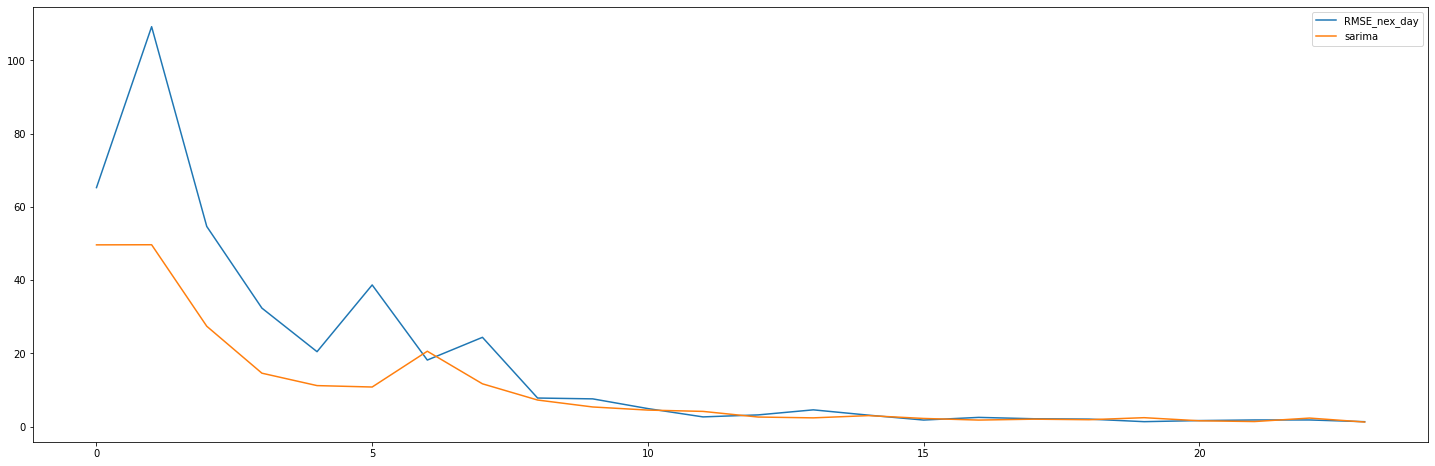

In [191]:
# merges both errors (cv and next day) and plot results
# as expected the next day predictions are worst
(
    nex_day_errors
    .merge(errors, left_on='h3_hex_nex_day', right_on='h3_hex')
    [['RMSE_nex_day', 'sarima']]
    .plot(figsize=(25,8), colormap='tab20c', ylabel='RMSE')
)